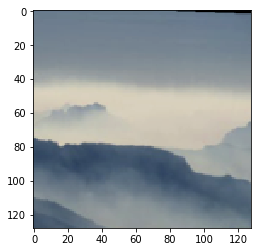

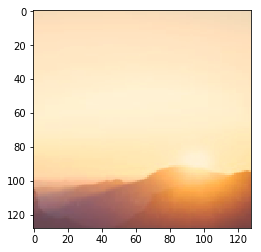

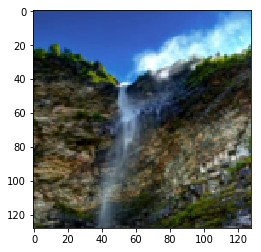

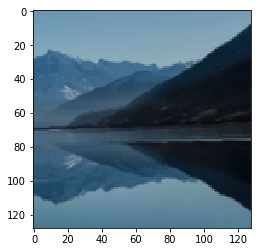

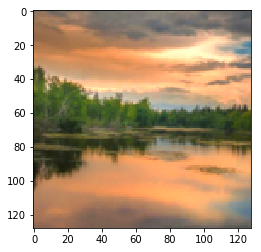

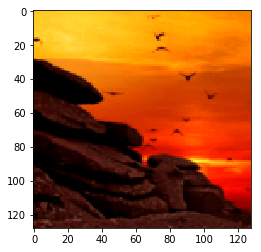

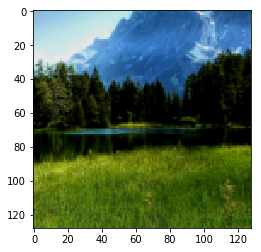

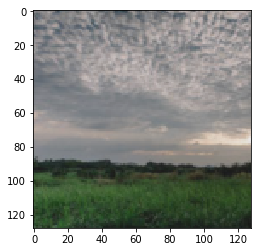

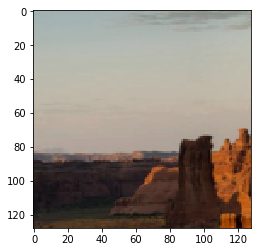

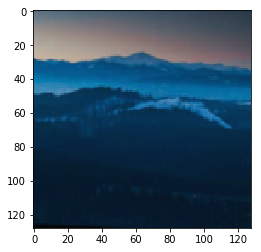

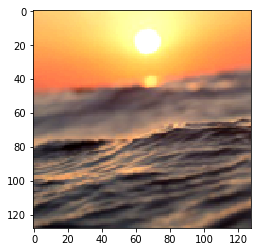

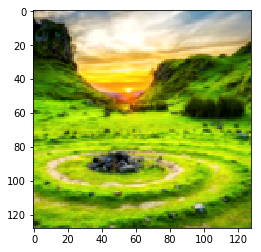

In [1]:
%matplotlib inline

import torch as th
import torchvision
import matplotlib.pyplot as plt
import Dataloader
import os

# select the device to be used for training
device = th.device("cuda" if th.cuda.is_available() else "cpu")

transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomRotation(3),
    torchvision.transforms.RandomCrop((256, 256)), # TODO: Random scale too
    torchvision.transforms.Resize((128, 128)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ColorJitter(.2, .2, .1, .01),
    torchvision.transforms.ToTensor(),
  ])

dataset_dir = os.environ['DATASET_DIR']
dataset = Dataloader.FlatDirectoryImageDataset(dataset_dir + '/pexels/landscapes', transform=transforms)

for i, d in enumerate(dataset):
    plt.imshow(d.permute(1, 2, 0).numpy())
    plt.show()
    if i > 10:
         break



In [2]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms

vgg = models.vgg13_bn(pretrained=True).to(device)

# freeze all model parameters
vgg.eval()
for param in vgg.parameters():
    param.requires_grad = False


def extract_features(x):
  # x = normalize(x)  # TODO
  #print(x.min(), x.max())
  
  # This is an approximation of the transform that the torchvision models want.
  x = (x - .5) * .6

  for i in range(12):
    x = vgg.features[i](x)
  return x

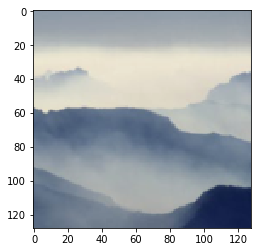

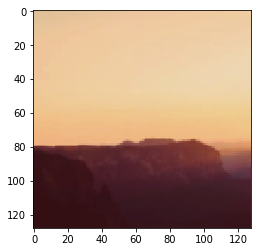

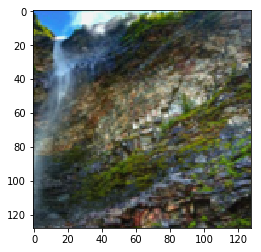

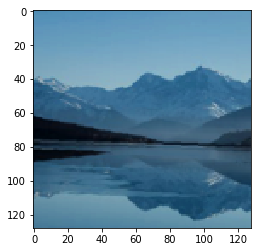

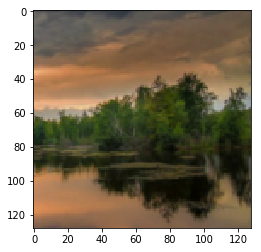

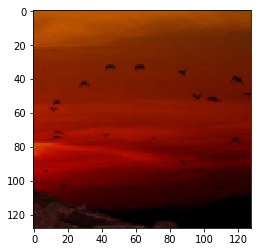

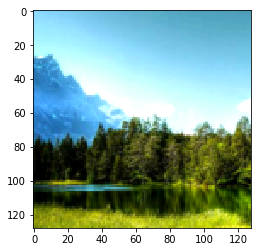

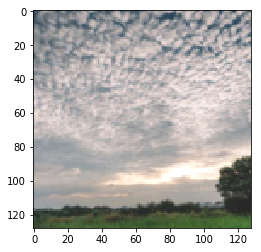

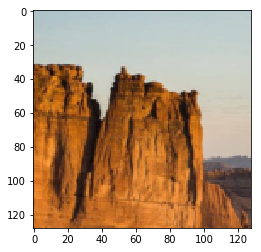

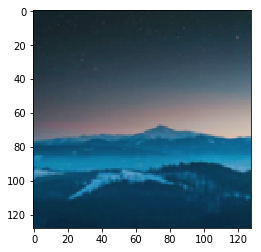

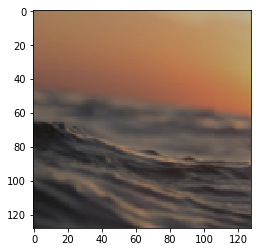

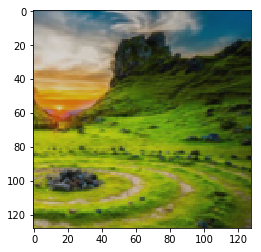

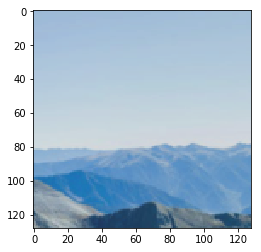

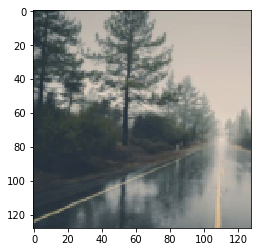

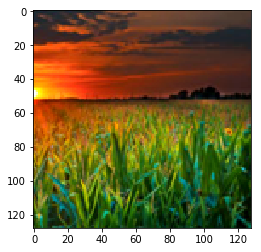

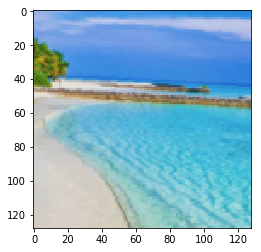

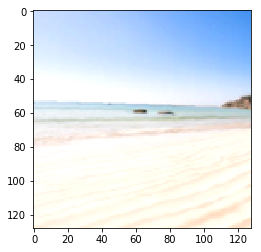

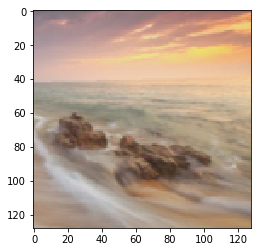

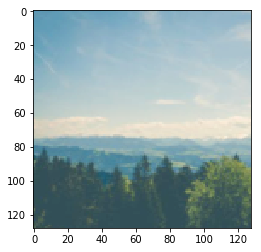

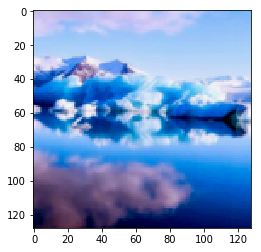

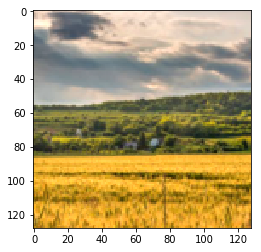

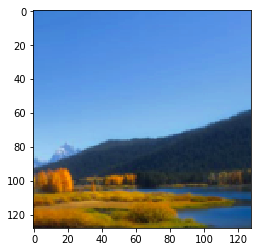

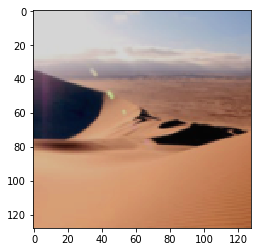

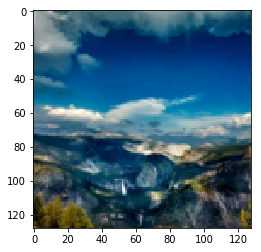

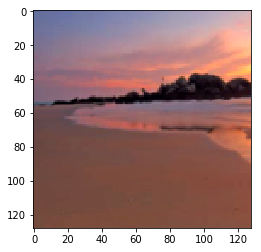

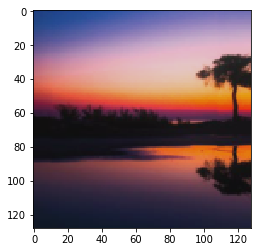

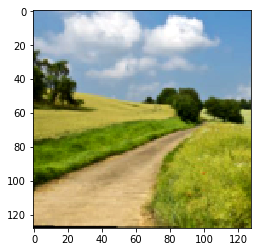

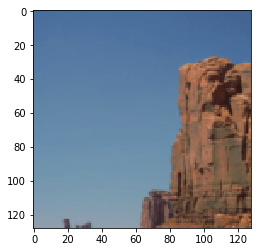

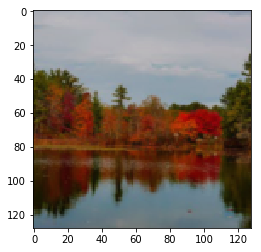

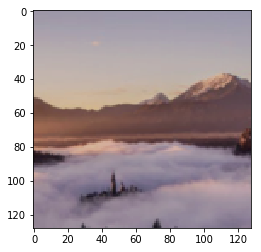

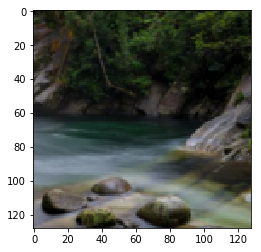

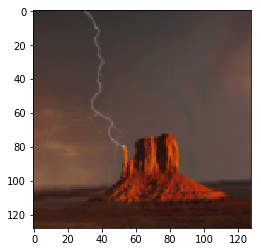

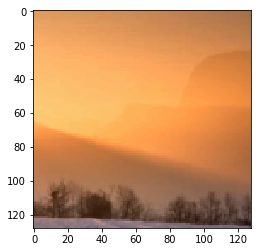

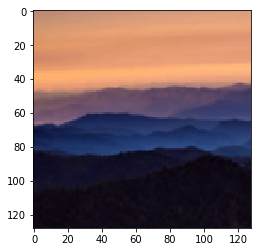

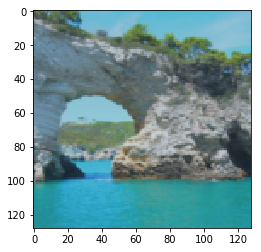

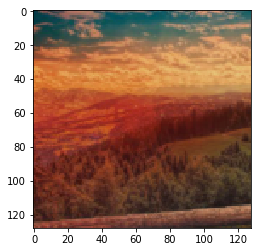

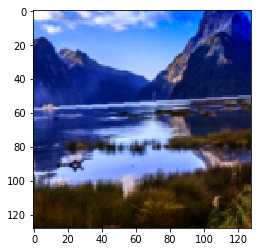

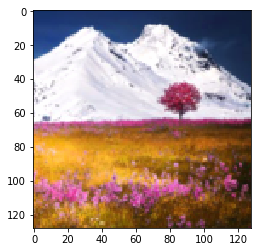

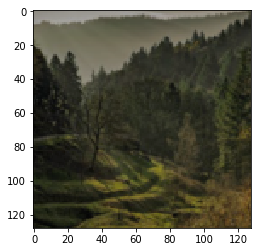

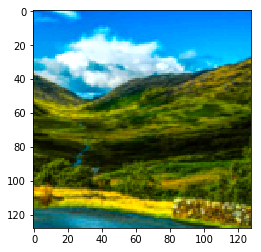

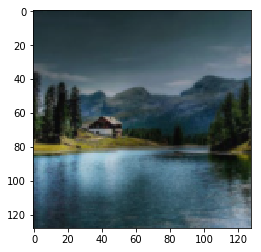

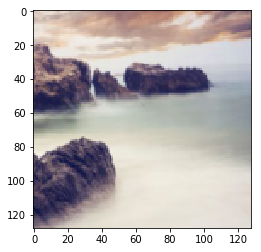

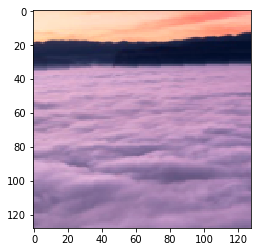

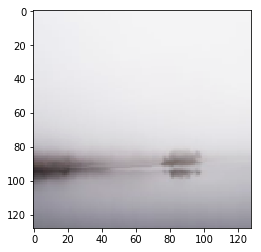

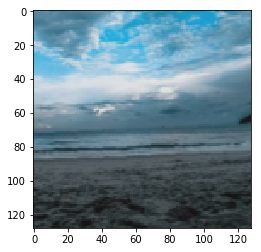

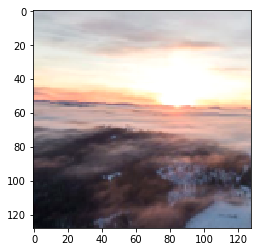

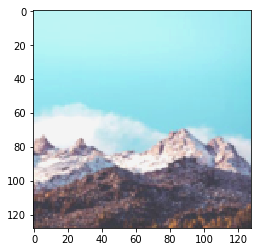

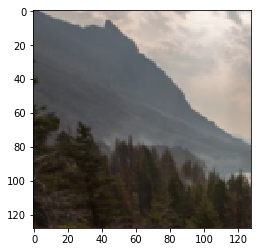

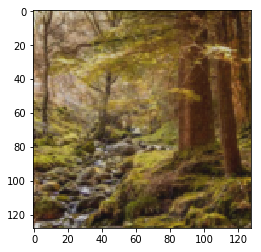

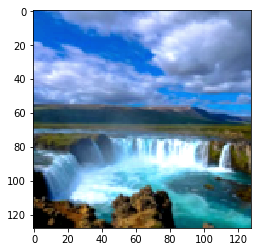

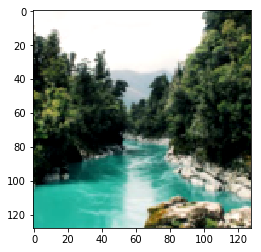

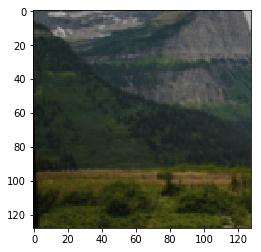

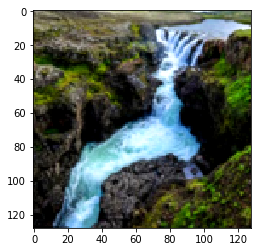

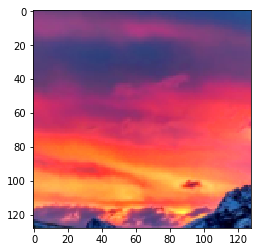

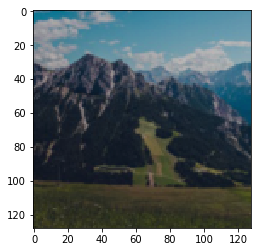

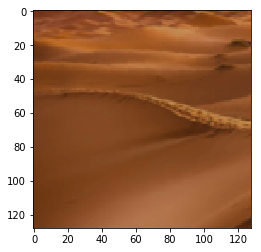

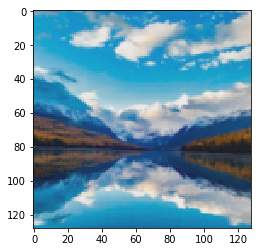

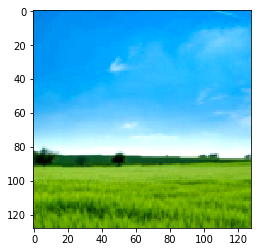

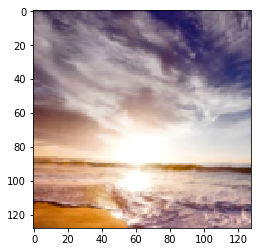

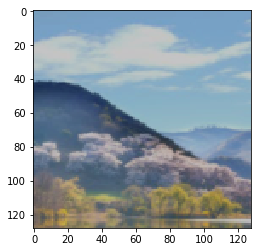

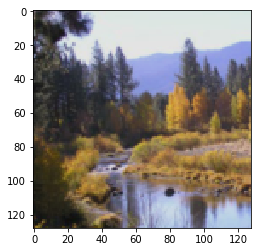

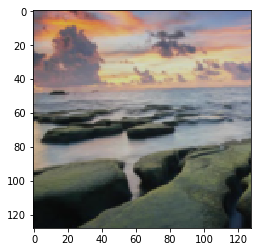

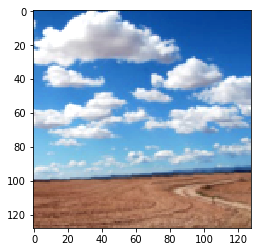

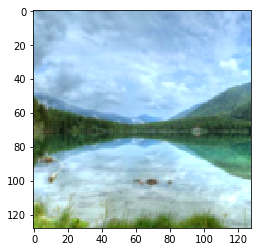

In [3]:
batch_size = 64

dataloader = torch.utils.data.DataLoader(dataset, batch_size)

target = next(iter(dataloader))
for i in range(batch_size):
    plt.imshow(target[i].permute(1, 2, 0).numpy())
    plt.show()


In [4]:
def create_grid(samples, img_file, scale_factor=1):
    """
    utility function to create a grid of GAN samples
    :param samples: generated samples for storing
    :param scale_factor: factor for upscaling the image
    :param img_file: name of file to write
    :return: None (saves a file)
    """
    from torchvision.utils import save_image
    from torch.nn.functional import interpolate

    # upsample the image
    if scale_factor > 1:
        samples = interpolate(samples, scale_factor=scale_factor)

    # save the images:
    save_image(samples, img_file, nrow=int(np.sqrt(len(samples))),
               normalize=True, scale_each=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

0.93426037


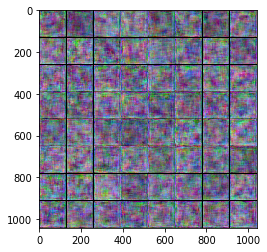

 10%|█         | 100/1000 [01:00<09:06,  1.65it/s]

0.14630353


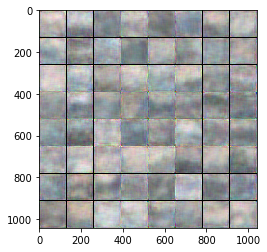

 20%|██        | 200/1000 [01:59<07:56,  1.68it/s]

0.09062566


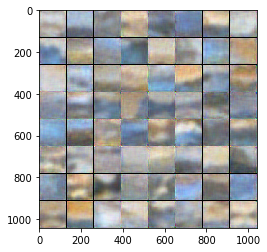

 30%|███       | 300/1000 [02:56<06:51,  1.70it/s]

0.07587101


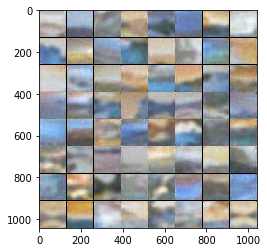

 40%|████      | 400/1000 [03:53<05:49,  1.71it/s]

0.06726323


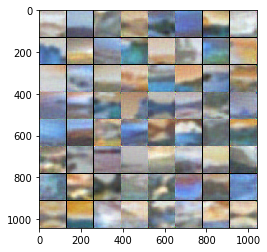

 50%|█████     | 500/1000 [04:50<04:50,  1.72it/s]

0.063759446


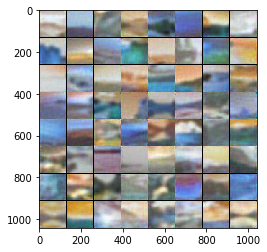

 60%|██████    | 600/1000 [05:47<03:51,  1.73it/s]

0.05925259


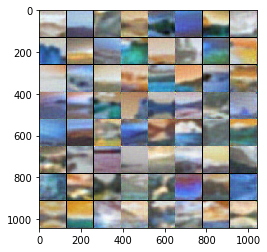

 70%|███████   | 700/1000 [06:45<02:53,  1.73it/s]

0.055752214


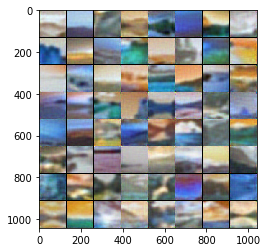

 80%|████████  | 800/1000 [07:42<01:55,  1.73it/s]

0.05436264


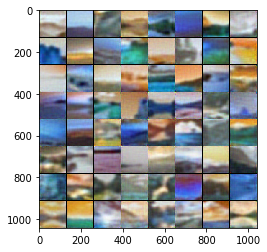

 90%|█████████ | 900/1000 [08:40<00:57,  1.73it/s]

0.052289784


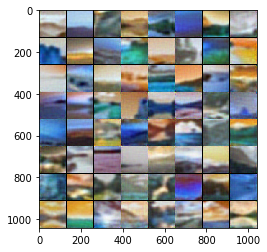

100%|██████████| 1000/1000 [09:38<00:00,  1.73it/s]


In [5]:
import PRO_GAN
import torch

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import cv2

latent_size = 128

g = PRO_GAN.Generator(depth=7, latent_size=latent_size).to(device)


anchor_latent_vectors = torch.randn(batch_size, latent_size, requires_grad=True, device=device)

optimizer = torch.optim.Adam(list(g.parameters()) + [anchor_latent_vectors], lr=.001)

target = target.to(device)

for i in tqdm(range(1000)):
    generated = g(anchor_latent_vectors, 5, 0)
    assert target.shape == generated.shape, "generated shape %s does not match target shape %s" % (str(generated.shape), str(target.shape))
    loss = torch.mean(torch.abs(target - generated))
    perceptual_loss = torch.mean(torch.abs(extract_features(target) - extract_features(generated)))
    
    filename = 'samples/%d.png' % i
    create_grid(generated, filename)
    if i % 100 == 0:
        print(loss.detach().cpu().numpy())
        plt.imshow(cv2.imread(filename))
        plt.show()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()




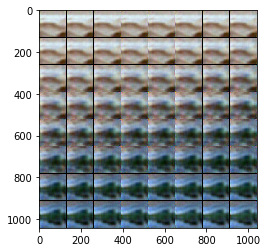

In [14]:
def interpolate_latent_vectors(vector_a, vector_b):
    vectors = torch.zeros(64, latent_size, device=device)
    for i in range(64):
        vectors[i] = vector_b * (i / 64.0) + vector_a * (1 - i / 64.0)
    generated = g(vectors, 5, 0)
    
    filename = 'samples/interpolation.png'
    create_grid(generated, filename)
    plt.imshow(cv2.imread(filename))
    plt.show()
        

interpolate_latent_vectors(anchor_latent_vectors[0], anchor_latent_vectors[4])